In [2]:
import numpy as np
import matplotlib.pyplot as plt

from openqcs import channel_, get_kraus_
from openqcs.tools import color_matrix, diagonalize
from scipy.linalg import expm, logm

In [7]:
X = np.matrix([[0,1],[1,0]])
Z = np.matrix([[1,0],[0,-1]])
Id = np.matrix(np.eye(2))
a = 0.5
b = 0.5
dt=0.001

def H_(a,b):
    return -a * np.kron(Z, Z) + b*(np.kron(X,Id) + np.kron(Id, X))

def T_(H, dt):
    if not isinstance(H, np.matrix):
        raise ValueError()
    return np.matrix(expm(-1j*H*dt))

H = H_(a,b)
T = T_(H, dt)

In [8]:
def entanglement_entropy(rho):
    return -np.trace(rho @ logm(rho))

In [9]:
t_total = 15.0
n_t = int(t_total//dt)

rho_in = np.matrix([[1,0],[0,0]], dtype=np.complex)
s0 = 1.0

rhos = np.zeros((n_t+1, 2, 2), dtype=np.complex)
rhos[0,:,:] = rho_in
eigenvals = np.zeros((n_t+1, 2), dtype=np.double)
eigenvals[0,:] = [1,0]

condition = np.zeros((n_t+1,), dtype=bool)
condition[0] = True

for i in range(n_t):
    Ks = get_kraus_(T**(i+1))
    rho = channel_(rho_in, Ks)
    rhos[i+1,:,:]=rho
    
    S, U = diagonalize(rho)
    l0 = S[0,0].real
    l1 = S[1,1].real
    eigenvals[i+1,:]=[l0,l1]
    
    if 1-s0 <= l0 <= s0:
        condition[i+1]=True
    else:
        condition[i+1]=False
    
    s0 = max(l0,l1)
    
t_data = np.arange(n_t+1)*dt


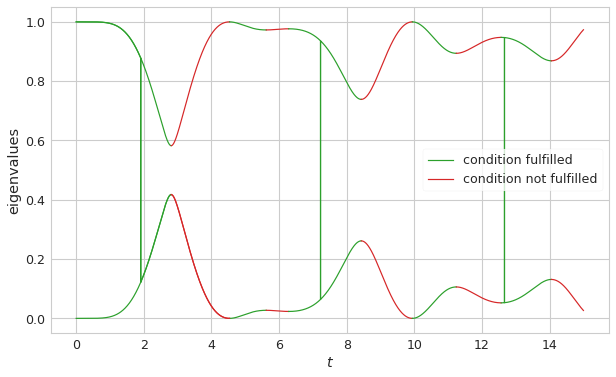

In [10]:
diffs = []
for i, c in enumerate(condition):
    if condition[i-1]!=condition[i]:
        diffs.append(i)
        
diffs.append(condition.shape[0])

N_parts = len(diffs)-1

plt.figure(figsize=(10,6))
for i in range(N_parts):
    vals = eigenvals[diffs[i]:diffs[i+1]]
    tvals = t_data[diffs[i]:diffs[i+1]]
    if condition[diffs[i]]:
        clr = "tab:green"
    else:
        clr = "tab:red"
    for j in range(2):
        plt.plot(tvals, vals[:,j], color=clr)
        
plt.plot(t_data[diffs[0]:diffs[1]], eigenvals[diffs[0]:diffs[1],0], color="tab:green", 
         label="condition fulfilled")
plt.plot(t_data[diffs[1]:diffs[2]], eigenvals[diffs[1]:diffs[2],0], color="tab:red", 
         label="condition not fulfilled")

plt.legend()
plt.xlabel("$t$")
plt.ylabel("eigenvalues")
        
plt.show()
        


/home/andreas/anaconda3/lib/python3.7/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:829: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)


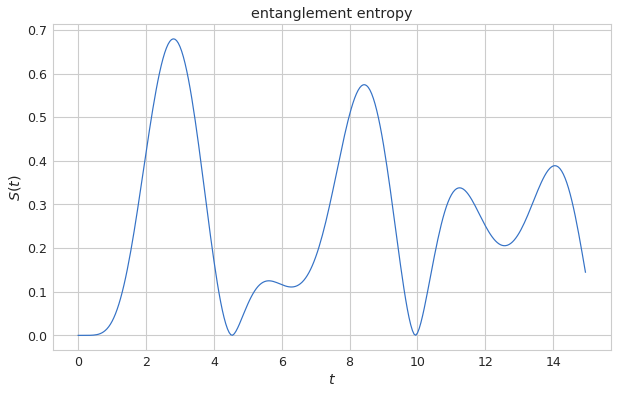

In [26]:
entangle = np.zeros((rhos.shape[0], ), dtype=np.double)
for i, rho in enumerate(rhos):
    S = entanglement_entropy(rho).real
    entangle[i] = S
    
plt.figure(figsize=(10,6))
plt.plot(t_data, entangle)
plt.ylabel("$S(t)$")
plt.xlabel("$t$")
plt.title("entanglement entropy")
plt.show()

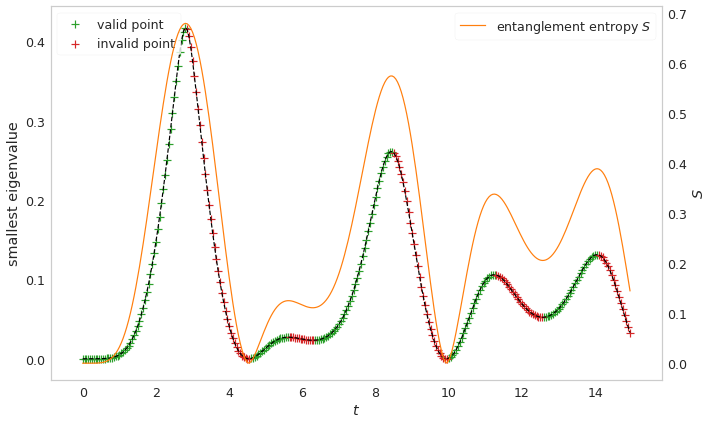

In [31]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(t_data, eigenvals[:,1], linestyle="--", color="black")
ax.scatter(t_pos, poss_points[:,1], color="tab:green", s=60, marker="+", label="valid point")
ax.scatter(t_npos, nposs_points[:,1], color="tab:red", s=60, marker="+", label="invalid point")
ax.legend(loc="upper left")
ax.set_xlabel("$t$")
ax.set_ylabel("smallest eigenvalue")
ax2 = ax.twinx()
ax2.plot(t_data, entangle, color="tab:orange", label="entanglement entropy $S$")
ax2.set_ylabel("$S$")
ax2.legend(loc="upper right")
ax.grid(False)
ax2.grid(False)
fig.tight_layout()

plt.show()

## Analytic part

Be $\rho$ a density matrix given by
\begin{equation}
    \rho(t) = U(t) \Lambda(t) U(t)^\dagger,
\end{equation}
with a arbitrary $U(t) \in U(2)$ and $\Lambda(t) = \text{diag}\{\lambda(t), 1-\lambda(t)\}$. Then the entanglement entropy becomes
\begin{equation}
    S(t) = - \log(1-\lambda(t)) + 2 \text{arctanh}(1-2\lambda(t)) \lambda(t).
\end{equation}


Hence for a finite $\text{d}t$ $\Delta S = S(t+dt) - S(t)$ becomes
\begin{equation}
\Delta S = \log\left(\frac{\lambda(t)-1}{\lambda(t+dt)-1}\right) - 2 \left(\lambda(t+dt) \text{arctanh}\left[1-2\lambda(t+dt)\right] - \lambda(t)\text{arctanh}\left[1-2\lambda(t)\right]\right)
\end{equation}

### Expansion of $\lambda(t+dt)$

Assume $\lambda$ behaves nicely such that we can exand it around $t$:
\begin{equation}
    \lambda(t+dt) = \lambda(t) + \alpha dt + \mathcal{O}(dt^2)
\end{equation}